# Imports

In [ ]:
import pandas as pd
import numpy as np
import re
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, fbeta_score
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

# Loading & Preprocessing

In [ ]:
#text processing function
def preprocess_text(text):
    text = str(text).lower() #converting text to lowercase
    text = re.sub(r'u\/\w+', '', text) #removing user mentions
    text = re.sub(r'r\/\w+', '', text) #removing subreddi mentions
    text = re.sub(r'http\S+', '', text) #removing links
    text = re.sub(r'\bfiller\b', '', text) #removing the word filler (it appeared very frequently in non-suicide posts)
    text = re.sub(r'[^a-z\s]', '', text) #removing symbols and punctuation
    text = re.sub(r'\s+', ' ', text).strip() #removing excess whitespace
    return text

#loading the data
df = pd.read_csv('Suicide_Detection.csv',  nrows=100000,  engine='python') #reading a limited number of lines for stability
df = df.dropna(subset=['text', 'class']) #removing rows with missing values
df['label'] = df['class'].map({'non-suicide': 0, 'suicide': 1}) #labeling classes
df['clean_text'] = df['text'].apply(preprocess_text) #applying the text processing function

#test/train split
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)

# TF-IDF Vectorization

In [ ]:
#tf-idf vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)
print(f"Shape of X_train_tfidf: {X_train_tfidf.shape}")
print(f"Shape of X_test_tfidf: {X_test_tfidf.shape}")

Shape of X_train_tfidf: (80000, 5000)
Shape of X_test_tfidf: (20000, 5000)


# USE Vectorization

In [ ]:
#use vectorization
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

#vecotrizing entries by batch to reduce memory use
def embed_text_batched(text_series, batch_size=512):
    embeddings = []
    for start in range(0, len(text_series), batch_size):
        batch = text_series.iloc[start:start + batch_size].tolist()
        embedded_batch = embed(batch).numpy()
        embeddings.append(embedded_batch) #embeding the current batch
        del embedded_batch #deleting the batch
        gc.collect() #freeing up memory
    return np.vstack(embeddings)

X_train_use =  embed_text_batched(X_train_text, batch_size=256)
X_test_use = embed_text_batched(X_test_text, batch_size=256)

print(f"Shape of X_train_use: {X_train_use.shape}")
print(f"Shape of X_test_use: {X_test_use.shape}")

Shape of X_train_use: (80000, 512)
Shape of X_test_use: (20000, 512)


# SVM


Evaluation (Threshold = 0.5):
              precision    recall  f1-score   support

 non-suicide       0.92      0.94      0.93     10016
     suicide       0.93      0.92      0.93      9984

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000

Recall: 0.9182
Precision: 0.9338
F2 Score: 0.9213


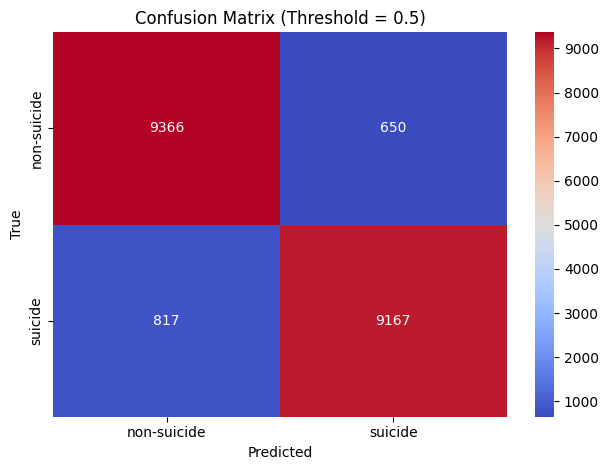


Evaluation (Threshold = 0.3):
              precision    recall  f1-score   support

 non-suicide       0.95      0.88      0.91     10016
     suicide       0.89      0.96      0.92      9984

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000

Recall: 0.9566
Precision: 0.8853
F2 Score: 0.9414


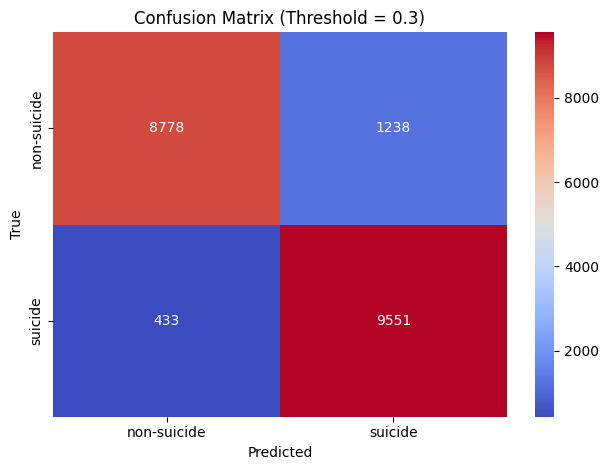

In [ ]:
base_svm = LinearSVC(class_weight='balanced', random_state=42) #our dataset balanced so we use balanced weights
svm = CalibratedClassifierCV(base_svm, cv=2) #setting the number of cross validation folds
svm.fit(X_train_tfidf, y_train) #training the mode

#make predictions
y_proba = svm.predict_proba(X_test_tfidf)[:, 1]

#metrics
for threshold in [0.5, 0.3]:
    y_pred = (y_proba > threshold).astype(int)
    print(f"\nEvaluation (Threshold = {threshold}):")
    print(classification_report(y_test, y_pred, target_names=['non-suicide', 'suicide']))

    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)

    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F2 Score: {f2:.4f}")

    #confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=['non-suicide', 'suicide'], yticklabels=['non-suicide', 'suicide'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix (Threshold = {threshold})")
    plt.tight_layout()
    plt.show()


Evaluation (Threshold = 0.5):
              precision    recall  f1-score   support

 non-suicide       0.94      0.94      0.94     10016
     suicide       0.94      0.94      0.94      9984

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000

Recall: 0.9435
Precision: 0.9356
F2 Score: 0.9419


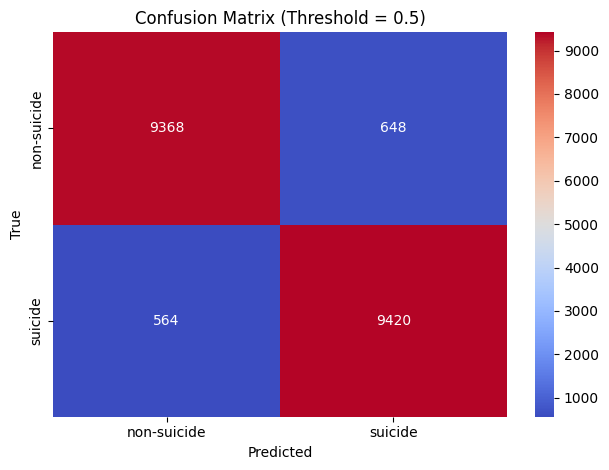


Evaluation (Threshold = 0.3):
              precision    recall  f1-score   support

 non-suicide       0.96      0.90      0.93     10016
     suicide       0.90      0.97      0.93      9984

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000

Recall: 0.9665
Precision: 0.9047
F2 Score: 0.9535


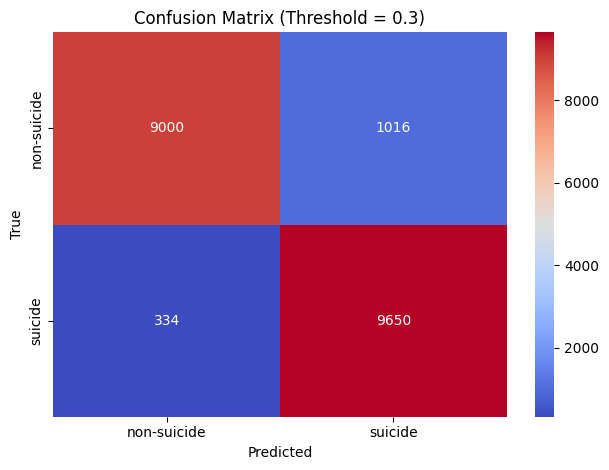

In [ ]:
base_svm = LinearSVC(class_weight='balanced', random_state=42)
svm = CalibratedClassifierCV(base_svm, cv=2)
svm.fit(X_train_use, y_train)

y_proba = svm.predict_proba(X_test_use)[:, 1]

for threshold in [0.5, 0.3]:
    y_pred = (y_proba > threshold).astype(int)
    print(f"\nEvaluation (Threshold = {threshold}):")
    print(classification_report(y_test, y_pred, target_names=['non-suicide', 'suicide']))

    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)

    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F2 Score: {f2:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=['non-suicide', 'suicide'], yticklabels=['non-suicide', 'suicide'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix (Threshold = {threshold})")
    plt.tight_layout()
    plt.show()


In [ ]:
# Make predictions on the test set using the SVM model trained on USE embeddings
y_pred_use = svm.predict(X_test_use)

# Create a DataFrame for easier handling
results_df_use = pd.DataFrame({
    'text': X_test_text,
    'true_label': y_test,
    'predicted_label': y_pred_use
})

# Filter for correctly classified suicide posts
correctly_classified_suicide = results_df_use[(results_df_use['true_label'] == 1) & (results_df_use['predicted_label'] == 1)]
print("--- Correctly Classified Suicide Posts (Examples) ---")
for i in range(min(5, len(correctly_classified_suicide))):
    print(f"Example {i+1}:\n{correctly_classified_suicide.iloc[i]['text']}\n")

# Filter for correctly classified non-suicide posts
correctly_classified_non_suicide = results_df_use[(results_df_use['true_label'] == 0) & (results_df_use['predicted_label'] == 0)]
print("--- Correctly Classified Non-Suicide Posts (Examples) ---")
for i in range(min(5, len(correctly_classified_non_suicide))):
    print(f"Example {i+1}:\n{correctly_classified_non_suicide.iloc[i]['text']}\n")

# Filter for misclassified suicide posts (predicted non-suicide)
misclassified_suicide = results_df_use[(results_df_use['true_label'] == 1) & (results_df_use['predicted_label'] == 0)]
print("--- Misclassified Suicide Posts (Predicted Non-Suicide) (Examples) ---")
for i in range(min(5, len(misclassified_suicide))):
    print(f"Example {i+1}:\n{misclassified_suicide.iloc[i]['text']}\n")

# Filter for misclassified non-suicide posts (predicted suicide)
misclassified_non_suicide = results_df_use[(results_df_use['true_label'] == 0) & (results_df_use['predicted_label'] == 1)]
print("--- Misclassified Non-Suicide Posts (Predicted Suicide) (Examples) ---")
for i in range(min(5, len(misclassified_non_suicide))):
    print(f"Example {i+1}:\n{misclassified_non_suicide.iloc[i]['text']}\n")

--- Correctly Classified Suicide Posts (Examples) ---
Example 1:
suicidal and cant tell anyoneive been to the psych unit times and a long term program three times and im only every time i seek help gets called and no help is received my mom says shes worried shell come home to me dead so she sends me to the hospital so they can watch me the hospital does not help they did some in the start but now all the workers berate me for having been there so many times i feel like crap about myself always and i cant tell anyone i know i cant talk on the suicide hotline because last time i did that the cops were over there quickly even though i just wanted to talk about it and i was carted off to the hospital the rules on here say i wont be tracked via my ip address so please please please tell me why i should live i still enjoy things but on a lower level i spend all my time on the internet and am attending online school i barely have any friends and the ones i do have dont really talk to me im s

# Random Forest


Evaluation (Threshold = 0.5):
              precision    recall  f1-score   support

 non-suicide       0.89      0.89      0.89     10016
     suicide       0.89      0.89      0.89      9984

    accuracy                           0.89     20000
   macro avg       0.89      0.89      0.89     20000
weighted avg       0.89      0.89      0.89     20000

Recall: 0.8921
Precision: 0.8872
F2 Score: 0.8911


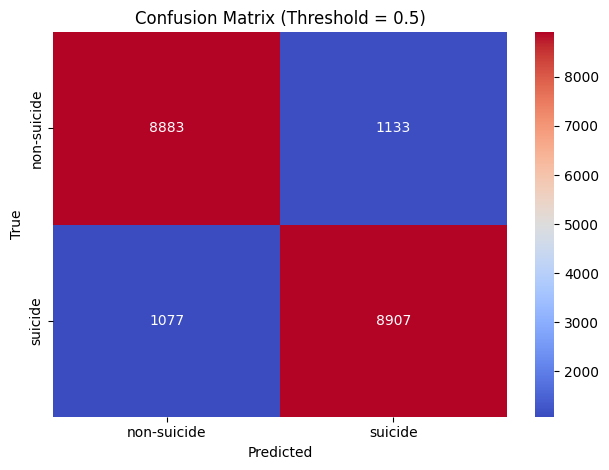


Evaluation (Threshold = 0.3):
              precision    recall  f1-score   support

 non-suicide       0.94      0.78      0.85     10016
     suicide       0.81      0.95      0.87      9984

    accuracy                           0.86     20000
   macro avg       0.87      0.86      0.86     20000
weighted avg       0.87      0.86      0.86     20000

Recall: 0.9512
Precision: 0.8087
F2 Score: 0.9188


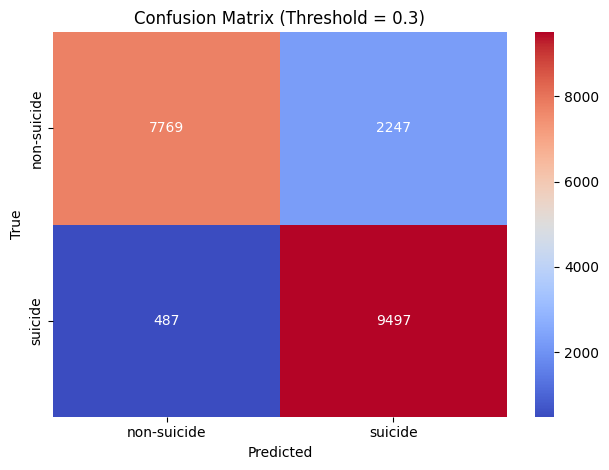

In [ ]:
rf = RandomForestClassifier(
    n_estimators=20, #number of trees used
    class_weight='balanced',
    random_state=42,
    n_jobs=-1 #use all avilable cpu cores
)
rf.fit(X_train_tfidf, y_train)

y_proba = rf.predict_proba(X_test_tfidf)[:, 1]

for threshold in [0.5, 0.3]:
    y_pred = (y_proba > threshold).astype(int)
    print(f"\nEvaluation (Threshold = {threshold}):")
    print(classification_report(y_test, y_pred, target_names=['non-suicide', 'suicide']))

    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)

    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F2 Score: {f2:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=['non-suicide', 'suicide'], yticklabels=['non-suicide', 'suicide'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix (Threshold = {threshold})")
    plt.tight_layout()
    plt.show()


Evaluation (Threshold = 0.5):
              precision    recall  f1-score   support

 non-suicide       0.90      0.94      0.92     10016
     suicide       0.93      0.90      0.92      9984

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000

Recall: 0.8995
Precision: 0.9331
F2 Score: 0.9061


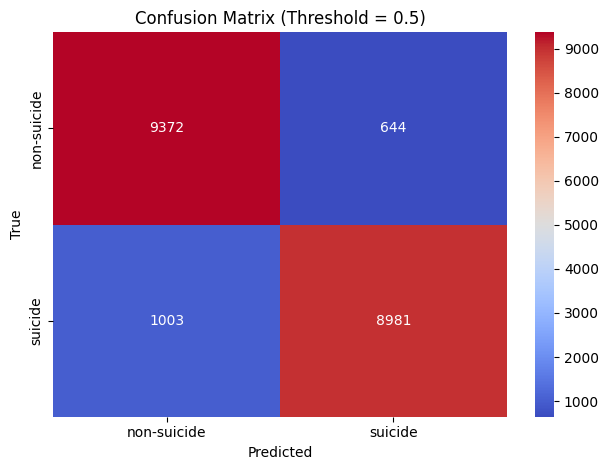


Evaluation (Threshold = 0.3):
              precision    recall  f1-score   support

 non-suicide       0.95      0.85      0.90     10016
     suicide       0.87      0.96      0.91      9984

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000

Recall: 0.9582
Precision: 0.8674
F2 Score: 0.9386


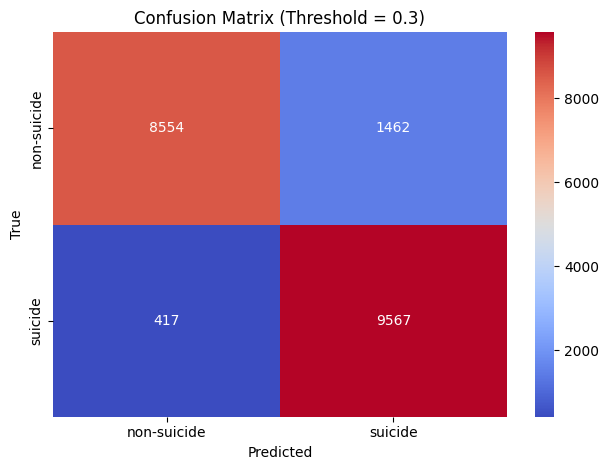

In [ ]:
rf = RandomForestClassifier(
    n_estimators=20,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_use, y_train)

y_proba = rf.predict_proba(X_test_use)[:, 1]

for threshold in [0.5, 0.3]:
    y_pred = (y_proba > threshold).astype(int)
    print(f"\nEvaluation (Threshold = {threshold}):")
    print(classification_report(y_test, y_pred, target_names=['non-suicide', 'suicide']))

    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)

    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F2 Score: {f2:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=['non-suicide', 'suicide'], yticklabels=['non-suicide', 'suicide'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix (Threshold = {threshold})")
    plt.tight_layout()
    plt.show()

# Logistic Regression


Evaluation (Threshold = 0.5):
              precision    recall  f1-score   support

 non-suicide       0.92      0.94      0.93     10016
     suicide       0.94      0.92      0.93      9984

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000

Recall: 0.9177
Precision: 0.9357
F2 Score: 0.9212


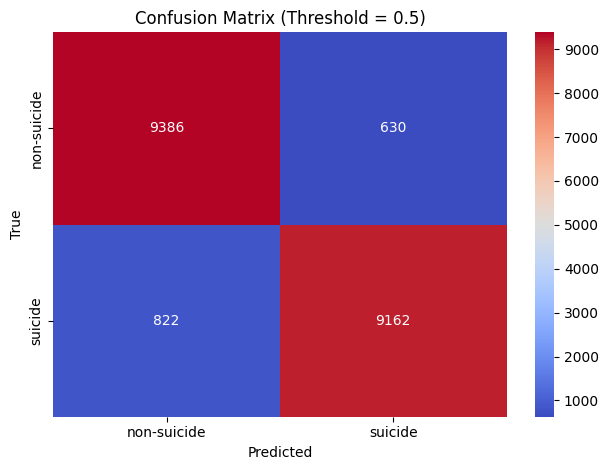


Evaluation (Threshold = 0.3):
              precision    recall  f1-score   support

 non-suicide       0.95      0.88      0.91     10016
     suicide       0.89      0.96      0.92      9984

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000

Recall: 0.9578
Precision: 0.8869
F2 Score: 0.9427


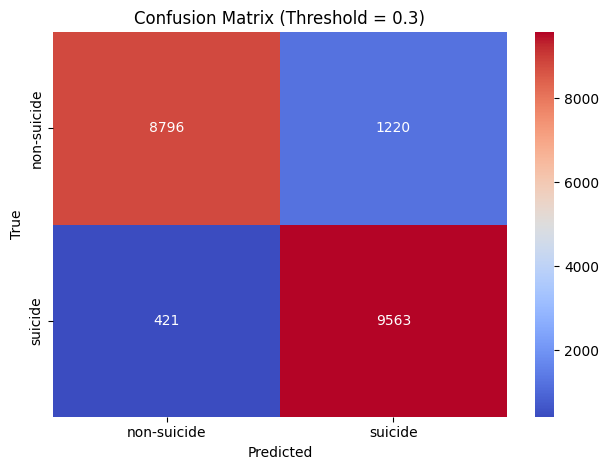

In [ ]:
logreg = LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)
logreg.fit(X_train_tfidf, y_train)

y_proba = logreg.predict_proba(X_test_tfidf)[:, 1]

for threshold in [0.5, 0.3]:
    y_pred = (y_proba > threshold).astype(int)
    print(f"\nEvaluation (Threshold = {threshold}):")
    print(classification_report(y_test, y_pred, target_names=['non-suicide', 'suicide']))

    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)

    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F2 Score: {f2:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=['non-suicide', 'suicide'], yticklabels=['non-suicide', 'suicide'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix (Threshold = {threshold})")
    plt.tight_layout()
    plt.show()


Evaluation (Threshold = 0.5):
              precision    recall  f1-score   support

 non-suicide       0.94      0.94      0.94     10016
     suicide       0.94      0.94      0.94      9984

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000

Recall: 0.9429
Precision: 0.9368
F2 Score: 0.9417


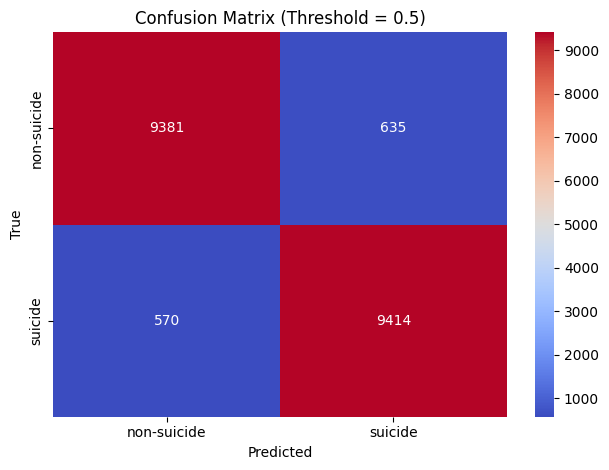


Evaluation (Threshold = 0.3):
              precision    recall  f1-score   support

 non-suicide       0.96      0.90      0.93     10016
     suicide       0.90      0.97      0.93      9984

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000

Recall: 0.9667
Precision: 0.9032
F2 Score: 0.9533


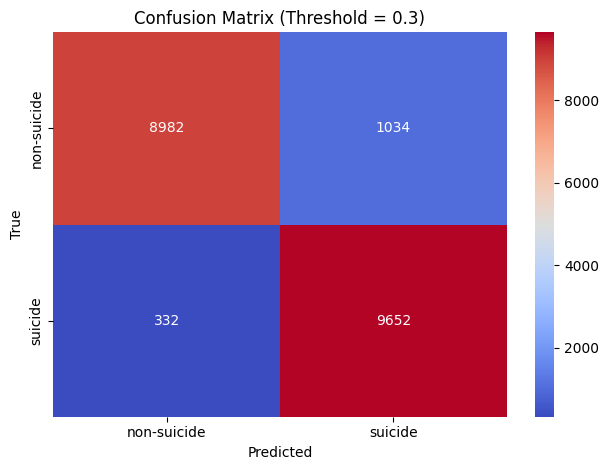

In [ ]:
logreg = LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)
logreg.fit(X_train_use, y_train)

y_proba = logreg.predict_proba(X_test_use)[:, 1]

for threshold in [0.5, 0.3]:
    y_pred = (y_proba > threshold).astype(int)
    print(f"\nEvaluation (Threshold = {threshold}):")
    print(classification_report(y_test, y_pred, target_names=['non-suicide', 'suicide']))

    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)

    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F2 Score: {f2:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=['non-suicide', 'suicide'], yticklabels=['non-suicide', 'suicide'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix (Threshold = {threshold})")
    plt.tight_layout()
    plt.show()

# FCNN

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 57s 43ms/step - accuracy: 0.8845 - loss: 0.2854 - val_accuracy: 0.9087 - val_loss: 0.2172
Epoch 2/20
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 82s 43ms/step - accuracy: 0.9443 - loss: 0.1555 - val_accuracy: 0.9025 - val_loss: 0.2386
Epoch 3/20
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 54s 43ms/step - accuracy: 0.9679 - loss: 0.0910 - val_accuracy: 0.9050 - val_loss: 0.2847
Epoch 4/20
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 54s 43ms/step - accuracy: 0.9879 - loss: 0.0342 - val_accuracy: 0.8988 - val_loss: 0.4824
Epoch 5/20
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 82s 43ms/step - accuracy: 0.9943 - loss: 0.0159 - val_accuracy: 0.9075 - val_loss: 0.6825
Epoch 6/20
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - accuracy: 0.9963 - loss: 0.0100 - val_accuracy: 0.9038 - val_loss: 0.7390
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step

Multi-layered Dense Evaluation (Threshold = 0.5):
              precision    recall  f1-score   support

 non-suicide       0.93      0.92      0.93     10016
     su

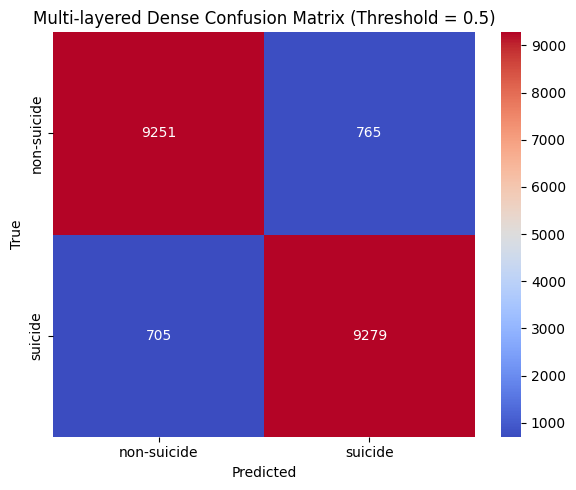


Multi-layered Dense Evaluation (Threshold = 0.3):
              precision    recall  f1-score   support

 non-suicide       0.95      0.88      0.92     10016
     suicide       0.89      0.95      0.92      9984

    accuracy                           0.92     20000
   macro avg       0.92      0.92      0.92     20000
weighted avg       0.92      0.92      0.92     20000

Recall: 0.9516
Precision: 0.8914
F2 Score: 0.9389


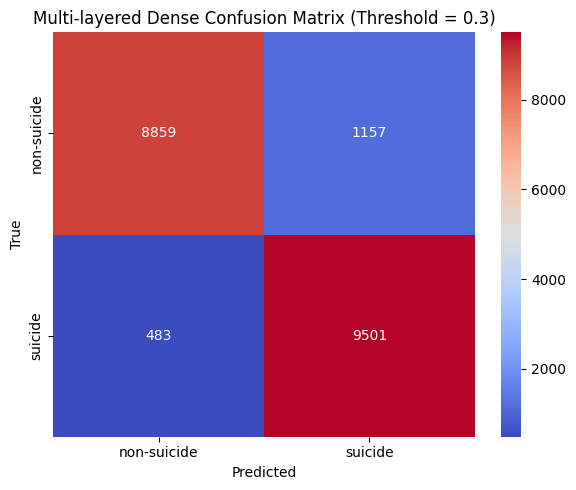

0

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

X_train_tfidf_flat = X_train_tfidf.toarray()
X_test_tfidf_flat = X_test_tfidf.toarray()

dense_model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_tfidf_flat.shape[1],)),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

dense_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = dense_model.fit(X_train_tfidf_flat, y_train,
                        epochs=20,
                        batch_size=64,
                        validation_split=0.01,
                        callbacks=[early_stopping],
                        verbose=1)

y_proba_dense = dense_model.predict(X_test_tfidf_flat).ravel()

for threshold in [0.5, 0.3]:
    y_pred_dense = (y_proba_dense > threshold).astype(int)
    print(f"\nMulti-layered Dense Evaluation (Threshold = {threshold}):")
    print(classification_report(y_test, y_pred_dense, target_names=['non-suicide', 'suicide']))

    recall = recall_score(y_test, y_pred_dense)
    precision = precision_score(y_test, y_pred_dense)
    f2 = fbeta_score(y_test, y_pred_dense, beta=2)

    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F2 Score: {f2:.4f}")

    cm = confusion_matrix(y_test, y_pred_dense)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=['non-suicide', 'suicide'], yticklabels=['non-suicide', 'suicide'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Multi-layered Dense Confusion Matrix (Threshold = {threshold})")
    plt.tight_layout()
    plt.show()

tf.keras.backend.clear_session()
del dense_model
gc.collect()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9040 - loss: 0.2405 - val_accuracy: 0.9362 - val_loss: 0.1685
Epoch 2/20
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9432 - loss: 0.1589 - val_accuracy: 0.9438 - val_loss: 0.1656
Epoch 3/20
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.9487 - loss: 0.1413 - val_accuracy: 0.9475 - val_loss: 0.1576
Epoch 4/20
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9537 - loss: 0.1256 - val_accuracy: 0.9350 - val_loss: 0.1683
Epoch 5/20
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.9600 - loss: 0.1095 - val_accuracy: 0.9350 - val_loss: 0.1635
Epoch 6/20
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9650 - loss: 0.0930 - val_accuracy: 0.9362 - val_loss: 0.1845
Epoch 7/20
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9706 - loss: 0.0806 - val_accuracy: 0.9400 - val_loss: 0.1940
Epoch 8/20
1238/1238 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9734 -

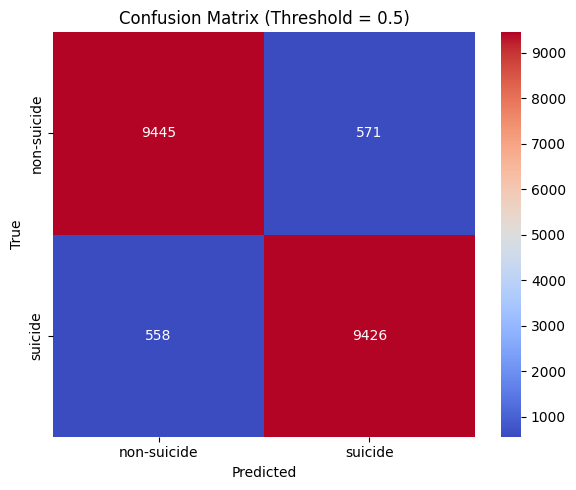


Evaluation (Threshold = 0.3):
              precision    recall  f1-score   support

 non-suicide       0.96      0.92      0.94     10016
     suicide       0.92      0.96      0.94      9984

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000

Recall: 0.9639
Precision: 0.9230
F2 Score: 0.9555


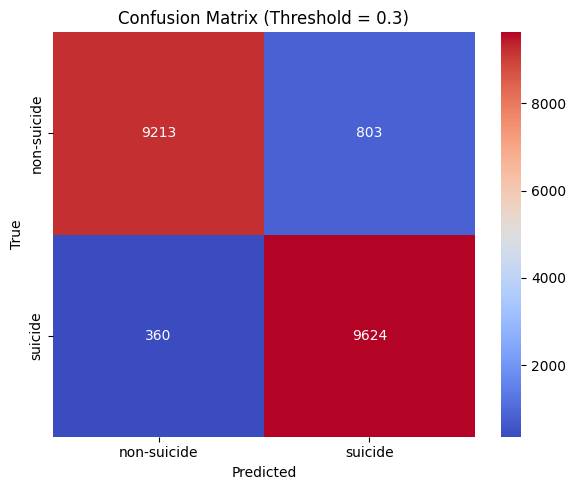

0

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

X_train_use_flat = X_train_use
X_test_use_flat = X_test_use

dense_model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_use_flat.shape[1],)),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

dense_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = dense_model.fit(X_train_use_flat, y_train,
                        epochs=20,
                        batch_size=64,
                        validation_split=0.01,
                        callbacks=[early_stopping],
                        verbose=1)

y_proba_dense = dense_model.predict(X_test_use_flat).ravel()

for threshold in [0.5, 0.3]:
    y_pred_dense = (y_proba_dense > threshold).astype(int)
    print(f"\nEvaluation (Threshold = {threshold}):")
    print(classification_report(y_test, y_pred_dense, target_names=['non-suicide', 'suicide']))

    recall = recall_score(y_test, y_pred_dense)
    precision = precision_score(y_test, y_pred_dense)
    f2 = fbeta_score(y_test, y_pred_dense, beta=2)

    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F2 Score: {f2:.4f}")

    cm = confusion_matrix(y_test, y_pred_dense)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=['non-suicide', 'suicide'], yticklabels=['non-suicide', 'suicide'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix (Threshold = {threshold})")
    plt.tight_layout()
    plt.show()

tf.keras.backend.clear_session()
del dense_model
gc.collect()

# SVM + Gender

Filtered dataset size: 136740
gender
Male      123460
Female     13280
Name: count, dtype: int64

Evaluation (Threshold = 0.5):
              precision    recall  f1-score   support

 non-suicide       0.91      0.91      0.91     10033
     suicide       0.95      0.95      0.95     17315

    accuracy                           0.94     27348
   macro avg       0.93      0.93      0.93     27348
weighted avg       0.94      0.94      0.94     27348

Recall: 0.9506
Precision: 0.9498
F2 Score: 0.9505


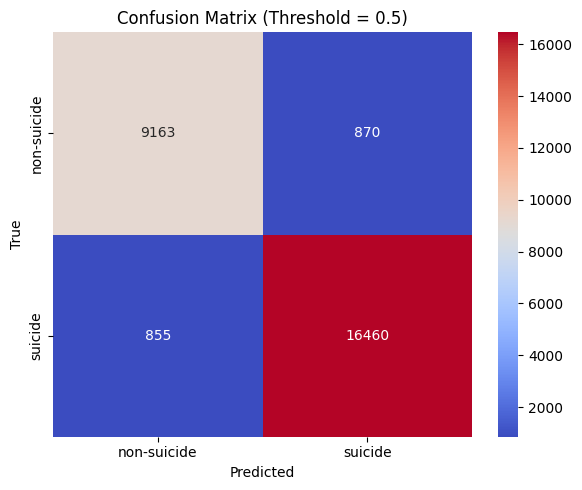


Evaluation (Threshold = 0.3):
              precision    recall  f1-score   support

 non-suicide       0.95      0.84      0.90     10033
     suicide       0.92      0.98      0.95     17315

    accuracy                           0.93     27348
   macro avg       0.94      0.91      0.92     27348
weighted avg       0.93      0.93      0.93     27348

Recall: 0.9768
Precision: 0.9158
F2 Score: 0.9639


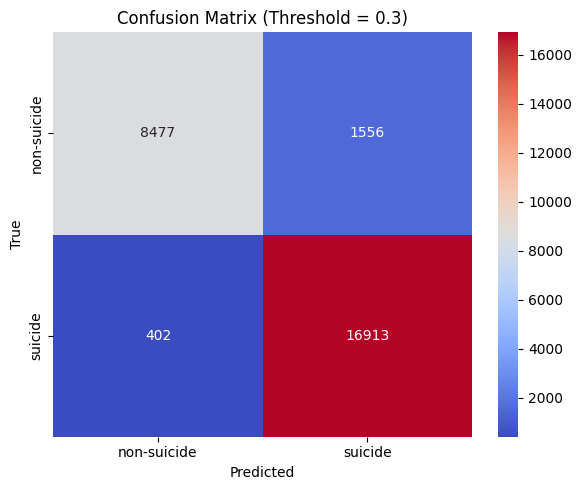

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, recall_score, precision_score, fbeta_score, confusion_matrix
from scipy.sparse import hstack, csr_matrix

def detect_gender(text):
    text = str(text).lower()

    male_keywords = r'\b(m|male|man|boy|he|him|his|guy|dude|gentleman|mr|sir|manly|masculine|boyish|masculinity|trans man|ftm|transmale|amab|assigned male)\b'
    female_keywords = r'\b(f|female|woman|girl|she|her|hers|lady|miss|ms|mrs|ma\'am|feminine|womanly|girly|femininity|trans woman|mtf|transfemale|afab|assigned female)\b'

    if re.search(male_keywords, text):
        return 'Male'
    elif re.search(female_keywords, text):
        return 'Female'
    return 'Unknown'

#text processing function
def preprocess_text(text):
    text = str(text).lower() #converting text to lowercase
    text = re.sub(r'u\/\w+', '', text) #removing user mentions
    text = re.sub(r'r\/\w+', '', text) #removing subreddi mentions
    text = re.sub(r'http\S+', '', text) #removing links
    text = re.sub(r'\bfiller\b', '', text) #removing the word filler (it appeared very frequently in non-suicide posts)
    text = re.sub(r'[^a-z\s]', '', text) #removing symbols and punctuation
    text = re.sub(r'\s+', ' ', text).strip() #removing excess whitespace
    return text

#loading the data
df = pd.read_csv('Suicide_Detection.csv',  engine='python') #reading a limited number of lines for stability
df = df.dropna(subset=['text', 'class']) #removing rows with missing values
df['label'] = df['class'].map({'non-suicide': 0, 'suicide': 1}) #labeling classes
df['clean_text'] = df['text'].apply(preprocess_text) #applying the text processing function

df['gender'] = df['text'].apply(detect_gender)
df = df[(df['gender'] != 'Unknown')].copy()

#test/train split
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)

print(f"Filtered dataset size: {len(df)}")
print(df['gender'].value_counts())

gender_encoded = pd.get_dummies(df['gender'], prefix='gender')

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_tfidf = tfidf.fit_transform(df['text'])

X_meta = np.hstack([
    gender_encoded.values
])
X_combined = hstack([X_tfidf, csr_matrix(X_meta)])
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, stratify=y, random_state=42)

base_svm = LinearSVC(class_weight='balanced', random_state=42)
svm = CalibratedClassifierCV(base_svm, cv=2)
svm.fit(X_train, y_train)

y_proba = svm.predict_proba(X_test)[:, 1]

for threshold in [0.5, 0.3]:
    y_pred = (y_proba> threshold).astype(int)
    print(f"\nEvaluation (Threshold = {threshold}):")
    print(classification_report(y_test, y_pred, target_names=['non-suicide', 'suicide']))

    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)

    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F2 Score: {f2:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=['non-suicide', 'suicide'], yticklabels=['non-suicide', 'suicide'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix (Threshold = {threshold})")
    plt.tight_layout()
    plt.show()

Filtered dataset size: 136740
gender
Male      123460
Female     13280
Name: count, dtype: int64

Evaluation (Threshold = 0.5):
              precision    recall  f1-score   support

 non-suicide       0.93      0.92      0.92     10033
     suicide       0.95      0.96      0.96     17315

    accuracy                           0.94     27348
   macro avg       0.94      0.94      0.94     27348
weighted avg       0.94      0.94      0.94     27348

Recall: 0.9615
Precision: 0.9513
F2 Score: 0.9595


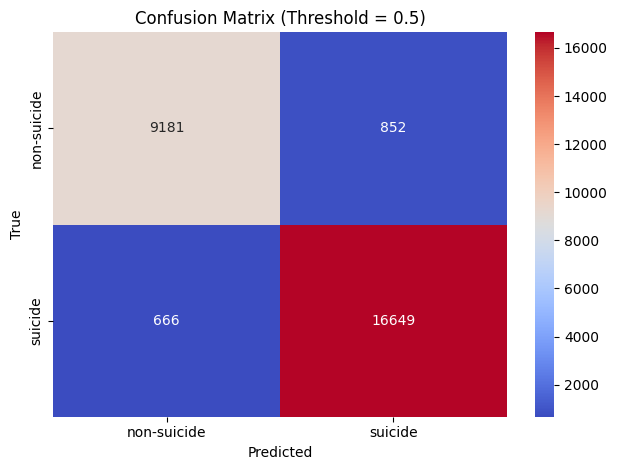


Evaluation (Threshold = 0.3):
              precision    recall  f1-score   support

 non-suicide       0.96      0.87      0.91     10033
     suicide       0.93      0.98      0.95     17315

    accuracy                           0.94     27348
   macro avg       0.94      0.92      0.93     27348
weighted avg       0.94      0.94      0.94     27348

Recall: 0.9794
Precision: 0.9288
F2 Score: 0.9688


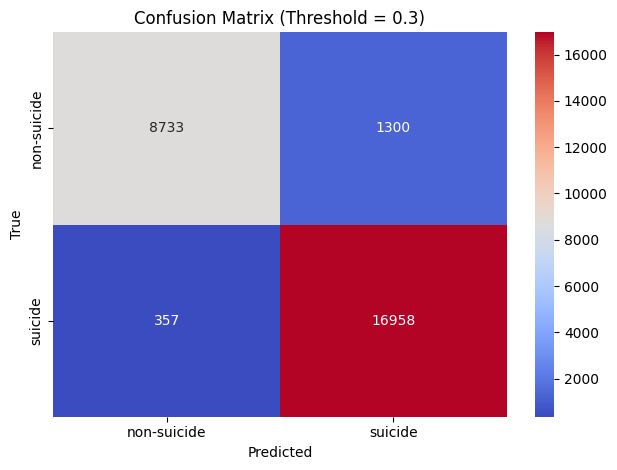

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, recall_score, precision_score, fbeta_score, confusion_matrix
from scipy.sparse import hstack, csr_matrix
import gc

def detect_gender(text):
    text = str(text).lower()

    male_keywords = r'\b(m|male|man|boy|he|him|his|guy|dude|gentleman|mr|sir|manly|masculine|boyish|masculinity|trans man|ftm|transmale|amab|assigned male)\b'
    female_keywords = r'\b(f|female|woman|girl|she|her|hers|lady|miss|ms|mrs|ma\'am|feminine|womanly|girly|femininity|trans woman|mtf|transfemale|afab|assigned female)\b'

    if re.search(male_keywords, text):
        return 'Male'
    elif re.search(female_keywords, text):
        return 'Female'
    return 'Unknown'

#text processing function
def preprocess_text(text):
    text = str(text).lower() #converting text to lowercase
    text = re.sub(r'u\/\w+', '', text) #removing user mentions
    text = re.sub(r'r\/\w+', '', text) #removing subreddi mentions
    text = re.sub(r'http\S+', '', text) #removing links
    text = re.sub(r'\bfiller\b', '', text) #removing the word filler (it appeared very frequently in non-suicide posts)
    text = re.sub(r'[^a-z\s]', '', text) #removing symbols and punctuation
    text = re.sub(r'\s+', ' ', text).strip() #removing excess whitespace
    return text

#loading the data
df = pd.read_csv('Suicide_Detection.csv',  engine='python') #reading a limited number of lines for stability
df = df.dropna(subset=['text', 'class']) #removing rows with missing values
df['label'] = df['class'].map({'non-suicide': 0, 'suicide': 1}) #labeling classes
df['clean_text'] = df['text'].apply(preprocess_text) #applying the text processing function

df['gender'] = df['text'].apply(detect_gender)
df = df[(df['gender'] != 'Unknown')].copy()

#test/train split
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)

print(f"Filtered dataset size: {len(df)}")
print(df['gender'].value_counts())


gender_encoded = pd.get_dummies(df['gender'], prefix='gender')

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def embed_text_batched(text_series, batch_size=256):
    embeddings = []
    for start in range(0, len(text_series), batch_size):
        batch = text_series.iloc[start:start+batch_size].tolist()
        embedded_batch = embed(batch).numpy()
        embeddings.append(embedded_batch)
        del embedded_batch
        gc.collect()
    return np.vstack(embeddings)

X_train_text, X_test_text, y_train, y_test, train_df, test_df = train_test_split(
    df['text'], df['label'], df, test_size=0.2, stratify=df['label'], random_state=42
)

X_train_embed = embed_text_batched(X_train_text)
X_test_embed = embed_text_batched(X_test_text)

X_train_meta = np.hstack([
    pd.get_dummies(train_df['gender'], prefix='gender').values
])
X_test_meta = np.hstack([
    pd.get_dummies(test_df['gender'], prefix='gender').values
])

X_train_final = np.hstack([X_train_embed, X_train_meta])
X_test_final = np.hstack([X_test_embed, X_test_meta])

base_svm = LinearSVC(class_weight='balanced', random_state=42)
svm = CalibratedClassifierCV(base_svm, cv=2)
svm.fit(X_train_final, y_train)

y_proba = svm.predict_proba(X_test_final)[:, 1]

for threshold in [0.5, 0.3]:
    y_pred = (y_proba > threshold).astype(int)
    print(f"\nEvaluation (Threshold = {threshold}):")
    print(classification_report(y_test, y_pred, target_names=['non-suicide', 'suicide']))

    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)

    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F2 Score: {f2:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=['non-suicide', 'suicide'], yticklabels=['non-suicide', 'suicide'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix (Threshold = {threshold})")
    plt.tight_layout()
    plt.show()


Checking the performance of gender alone

Filtered dataset size: 136740
gender
Male      123460
Female     13280
Name: count, dtype: int64
class
suicide        86573
non-suicide    50167
Name: count, dtype: int64

Evaluation (Threshold = 0.5):
              precision    recall  f1-score   support

 non-suicide       0.63      0.17      0.26     10033
     suicide       0.66      0.94      0.78     17315

    accuracy                           0.66     27348
   macro avg       0.65      0.56      0.52     27348
weighted avg       0.65      0.66      0.59     27348

Recall: 0.9430
Precision: 0.6615
F2 Score: 0.8690


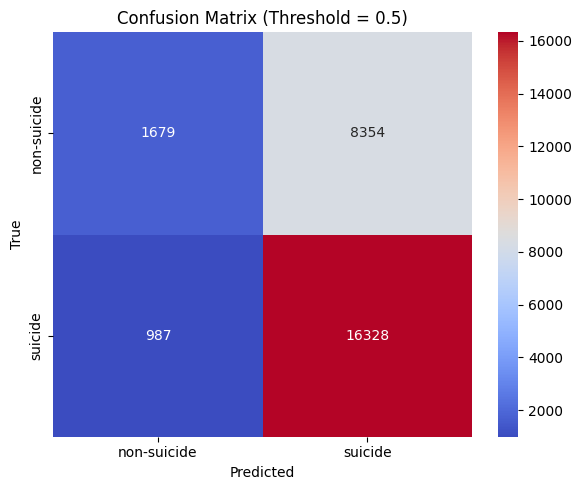


Evaluation (Threshold = 0.3):
              precision    recall  f1-score   support

 non-suicide       0.00      0.00      0.00     10033
     suicide       0.63      1.00      0.78     17315

    accuracy                           0.63     27348
   macro avg       0.32      0.50      0.39     27348
weighted avg       0.40      0.63      0.49     27348

Recall: 1.0000
Precision: 0.6331
F2 Score: 0.8961


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


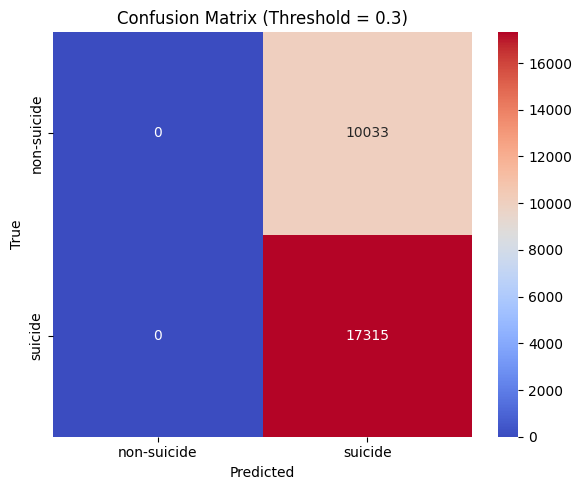

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, recall_score, precision_score, fbeta_score, confusion_matrix
from scipy.sparse import hstack, csr_matrix

def detect_gender(text):
    text = str(text).lower()

    male_keywords = r'\b(m|male|man|boy|he|him|his|guy|dude|gentleman|mr|sir|manly|masculine|boyish|masculinity|trans man|ftm|transmale|amab|assigned male)\b'
    female_keywords = r'\b(f|female|woman|girl|she|her|hers|lady|miss|ms|mrs|ma\'am|feminine|womanly|girly|femininity|trans woman|mtf|transfemale|afab|assigned female)\b'

    if re.search(male_keywords, text):
        return 'Male'
    elif re.search(female_keywords, text):
        return 'Female'
    return 'Unknown'

#loading the data
df = pd.read_csv('Suicide_Detection.csv',  engine='python') #reading a limited number of lines for stability
df = df.dropna(subset=['text', 'class']) #removing rows with missing values
df['label'] = df['class'].map({'non-suicide': 0, 'suicide': 1}) #labeling classes


df['gender'] = df['text'].apply(detect_gender)
df = df[(df['gender'] != 'Unknown')].copy()

#test/train split
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['gender'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)

print(f"Filtered dataset size: {len(df)}")
print(df['gender'].value_counts())

gender_encoded = pd.get_dummies(df['gender'], prefix='gender')

X_meta = np.hstack([
    gender_encoded.values
])
X_combined = hstack([csr_matrix(X_meta)])
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, stratify=y, random_state=42)

base_svm = LinearSVC(class_weight='balanced', random_state=42)
svm = CalibratedClassifierCV(base_svm, cv=2)
svm.fit(X_train, y_train)

y_proba = svm.predict_proba(X_test)[:, 1]
print(df['class'].value_counts())
for threshold in [0.5, 0.3]:
    y_pred = (y_proba> threshold).astype(int)
    print(f"\nEvaluation (Threshold = {threshold}):")
    print(classification_report(y_test, y_pred, target_names=['non-suicide', 'suicide']))

    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)

    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F2 Score: {f2:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=['non-suicide', 'suicide'], yticklabels=['non-suicide', 'suicide'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix (Threshold = {threshold})")
    plt.tight_layout()
    plt.show()

#***Data Analysis: Suicide By Age Group***

/tmp/ipython-input-8-381599605.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age'] = df['age'].astype(int)
/tmp/ipython-input-8-381599605.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)
/tmp/ipython-input-8-381599605.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=g

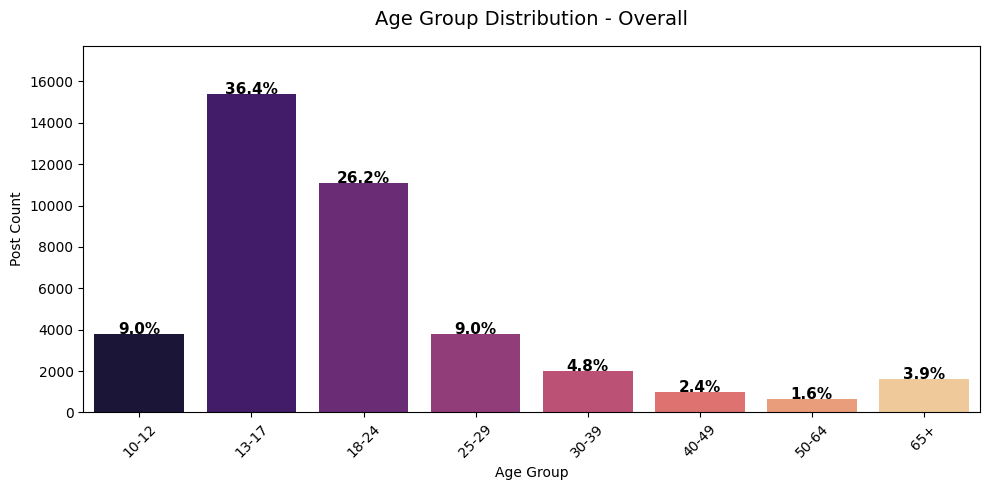

/tmp/ipython-input-8-381599605.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=group_df, x='age_group', order=labels, palette='magma')


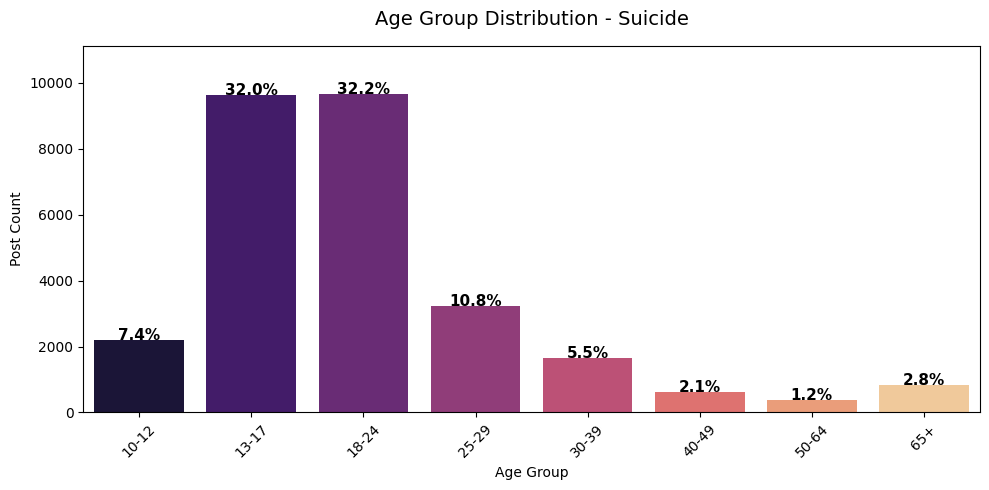

/tmp/ipython-input-8-381599605.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=group_df, x='age_group', order=labels, palette='magma')


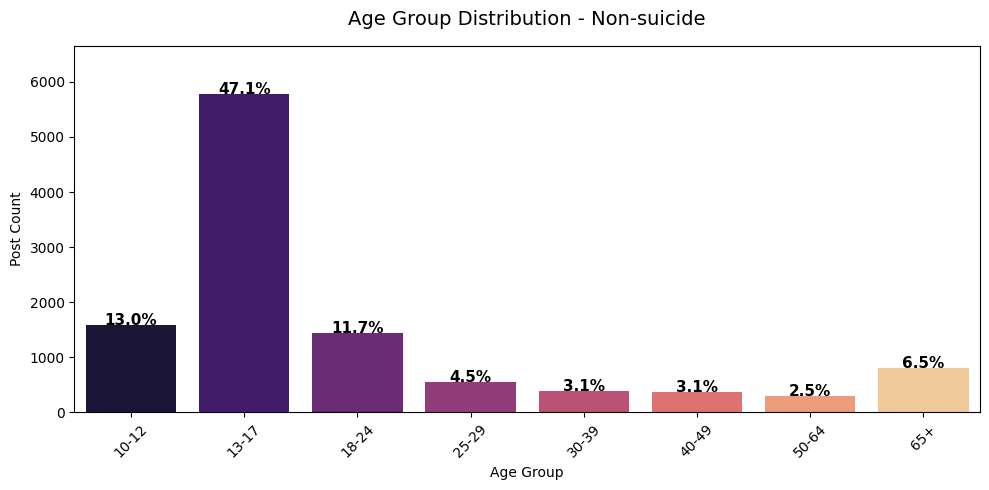

In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def extract_age(text):
    text = str(text).lower()

    school_year_to_age = {
        'freshman': 14,
        'sophomore': 15,
        'junior': 16,
        'senior': 17
    }
    for term, age in school_year_to_age.items():
        if term in text:
            return age

    contextual_patterns = [
        r'(?:^|\s)(?:i am|i\'m|im|me)\s*(\d{2})\s*(?:yo|y/o|years? old|yrs?)?\b',
        r'(?:^|\s)(?:turn(?:ing)?|turned)\s*(\d{2})\b',
        r'(?:^|\s)age(?:d)?\s*(\d{2})\b',
        r'\b(\d{2})\s*(?:yo|y/o|yrs?|years? old)\b',
        r'\b(?:f|female|m|male)\s*(\d{2})\b',
        r'\b(\d{2})\s*(?:f|female|m|male)\b',
        r'(?:^|\s)(?:just)?\s*(?:hit|reached|celebrated|turning)\s*(\d{2})\b',
        r'(\d{2})\s*(?:birthday|b-day|bday)\b',
        r'\b(?:i\'ll|i will|i’m going to)\s*(?:be|turn)\s*(\d{2})\b',
        r'\b(\d{2})(?=\s*in\s*(?:school|grade))'
    ]

    for pattern in contextual_patterns:
        match = re.search(pattern, text)
        if match:
            age = int(match.group(1))
            if 10 <= age <= 100:
                return age

    for match in re.finditer(r'(?<!\d)(\d{2})(?!\d)', text):
        age = int(match.group(1))
        if 10 <= age <= 100:
            start, end = match.span()
            context_window = text[max(0, start - 25):min(len(text), end + 25)]
            if any(word in context_window for word in [
                'year', 'years', 'old', 'age', 'born', 'since', 'birthday',
                'school', 'teen', 'grade', 'turn', 'turned', 'i am', 'i\'m', 'me',
                'class', 'middle', 'high', 'elementary', 'freshman', 'sophomore',
                'junior', 'senior', 'vote', 'permit', 'license', 'puberty',
                'college', 'driving', 'prom', 'graduated', 'graduate', 'next year', 'becoming'
            ]):
                return age

    return np.nan

df = pd.read_csv('Suicide_Detection.csv', engine='python')
df = df.dropna(subset=['text', 'class'])

df['age'] = df['text'].apply(extract_age)
df = df.dropna(subset=['age'])
df['age'] = df['age'].astype(int)

bins = [10, 13, 18, 25, 30, 40, 50, 65, 100]
labels = ['10-12', '13-17', '18-24', '25-29', '30-39', '40-49', '50-64', '65+']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)

groups = {
    'Overall': df,
    'Suicide': df[df['class'] == 'suicide'],
    'Non-suicide': df[df['class'] == 'non-suicide']
}

for group_name, group_df in groups.items():
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(data=group_df, x='age_group', order=labels, palette='magma')

    total = len(group_df)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 2,
                f'{height/total:.1%}',
                ha='center', color='black', fontsize=11, fontweight='bold')

    plt.title(f'Age Group Distribution - {group_name}', fontsize=14, pad=15)
    plt.xlabel('Age Group')
    plt.ylabel('Post Count')
    plt.xticks(rotation=45)
    plt.ylim(0, max([p.get_height() for p in ax.patches]) * 1.15)
    plt.tight_layout()
    plt.show()

# ***Data Analysis: Suicide By Gender***

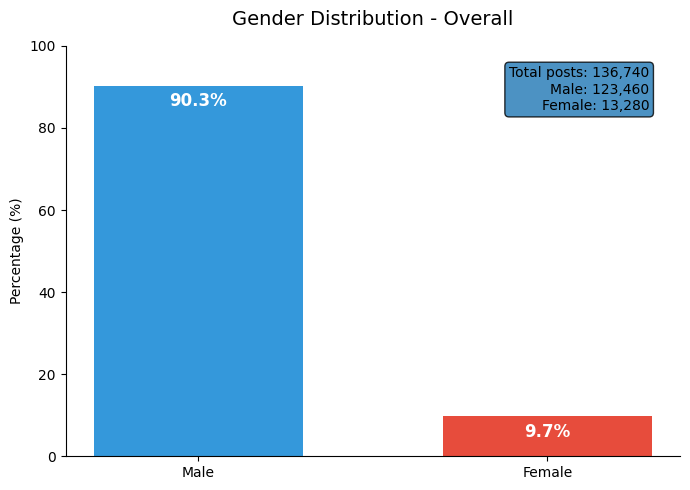

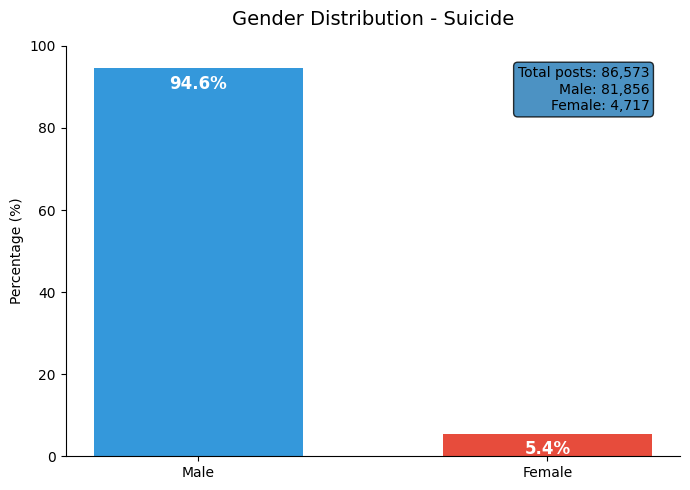

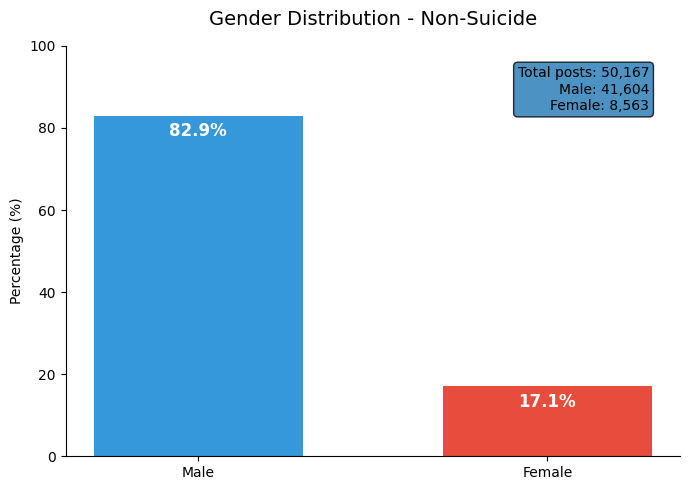

In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt

def detect_gender(text):
    text = str(text).lower()

    male_keywords = r'\b(m|male|man|boy|he|him|his|guy|dude|gentleman|mr|sir|manly|masculine|boyish|masculinity|trans man|ftm|transmale|amab|assigned male)\b'
    female_keywords = r'\b(f|female|woman|girl|she|her|hers|lady|miss|ms|mrs|ma\'am|feminine|womanly|girly|femininity|trans woman|mtf|transfemale|afab|assigned female)\b'

    if re.search(male_keywords, text):
        return 'Male'
    elif re.search(female_keywords, text):
        return 'Female'
    return 'Unknown'

#text processing function
def preprocess_text(text):
    text = str(text).lower() #converting text to lowercase
    text = re.sub(r'u\/\w+', '', text) #removing user mentions
    text = re.sub(r'r\/\w+', '', text) #removing subreddi mentions
    text = re.sub(r'http\S+', '', text) #removing links
    text = re.sub(r'\bfiller\b', '', text) #removing the word filler (it appeared very frequently in non-suicide posts)
    text = re.sub(r'[^a-z\s]', '', text) #removing symbols and punctuation
    text = re.sub(r'\s+', ' ', text).strip() #removing excess whitespace
    return text

#loading the data
df = pd.read_csv('Suicide_Detection.csv',  engine='python') #reading a limited number of lines for stability
df = df.dropna(subset=['text', 'class']) #removing rows with missing values
df['label'] = df['class'].map({'non-suicide': 0, 'suicide': 1}) #labeling classes
df['clean_text'] = df['text'].apply(preprocess_text) #applying the text processing function

df['gender'] = df['text'].apply(detect_gender)
df = df[(df['gender'] != 'Unknown')].copy()

# --- Plotting for Each Group ---
groups = {
    'Overall': df,
    'Suicide': df[df['class'] == 'suicide'],
    'Non-Suicide': df[df['class'] == 'non-suicide']
}

for title, group_df in groups.items():
    gender_counts = group_df['gender'].value_counts()
    percentages = (gender_counts / len(group_df)) * 100

    plt.figure(figsize=(7, 5))
    bars = plt.bar(percentages.index, percentages.values,
                   color=['#3498db', '#e74c3c'], width=0.6)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height - 5,
                 f'{height:.1f}%',
                 ha='center', color='white', fontweight='bold', fontsize=12)

    plt.title(f'Gender Distribution - {title}', fontsize=14, pad=15)
    plt.ylabel('Percentage (%)')
    plt.ylim(0, 100)
    plt.gca().spines[['top', 'right']].set_visible(False)

    # Add annotation box
    plt.annotate(f'Total posts: {len(group_df):,}\n'
                 f'Male: {gender_counts.get("Male", 0):,}\n'
                 f'Female: {gender_counts.get("Female", 0):,}',
                 xy=(0.95, 0.95), xycoords='axes fraction',
                 ha='right', va='top', bbox=dict(boxstyle='round', alpha=0.8))

    plt.tight_layout()
    plt.show()

# ***Data Analysis: KMeans Clustering***


Posts per Cluster:
cluster
0    12606
1     7394
Name: count, dtype: int64

Silhouette Score (higher = better separation): 0.0621

Class distribution within each cluster:
class    non-suicide   suicide
cluster                       
0           0.739568  0.260432
1           0.109819  0.890181


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


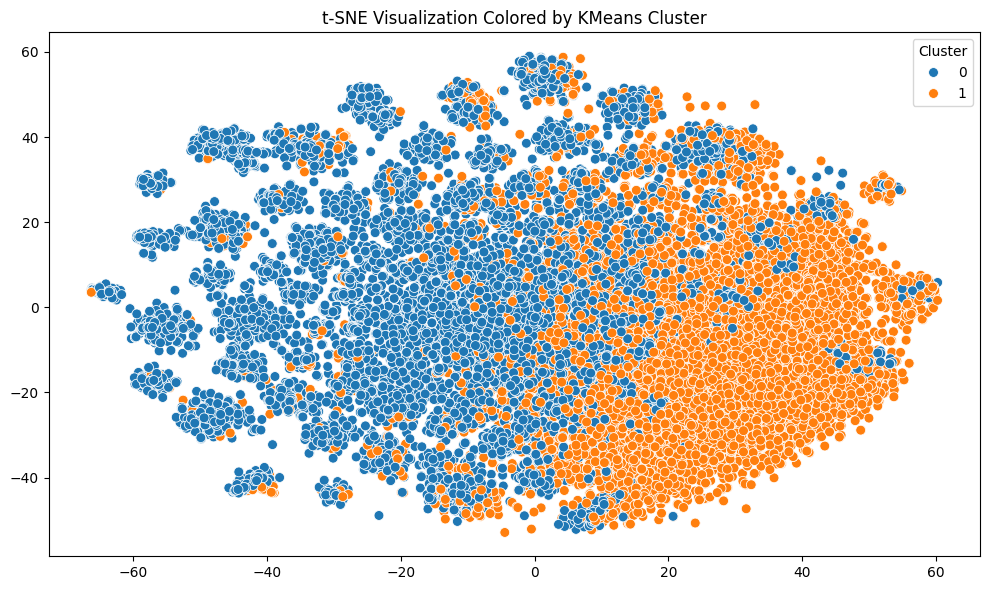

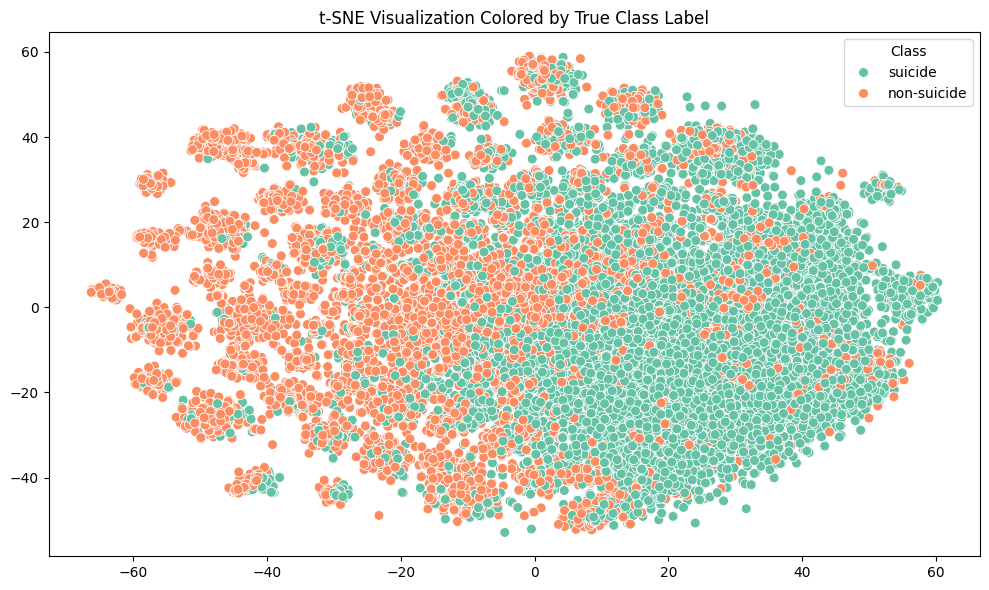


Cluster Purity (majority class % per cluster):
Cluster 0: 73.96% pure
Cluster 1: 89.02% pure

Sample post from each cluster:

--- Cluster 0 Sample ---
Ex Wife Threatening SuicideRecently I left my wife for good because she has cheated on me twice and lied to me so much that I have decided to refuse to go back to her. As of a few days ago, she began threatening suicide. I have tirelessly spent these paat few days talking her out of it and she keeps hesitating because she wants to believe I'll come back. I know a lot of people will threaten this in order to get their way, but what happens if she really does? What do I do and how am I supposed to handle her death on my hands? I still love my wife but I cannot deal with getting cheated on again and constantly feeling insecure. I'm worried today may be the day she does it and I hope so much it doesn't happen. suicide


--- Cluster 0 Sample ---
Am I weird I don't get affected by compliments if it's coming from someone I know irl but I feel 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

#text processing function
def preprocess_text(text):
    text = str(text).lower() #converting text to lowercase
    text = re.sub(r'u\/\w+', '', text) #removing user mentions
    text = re.sub(r'r\/\w+', '', text) #removing subreddi mentions
    text = re.sub(r'http\S+', '', text) #removing links
    text = re.sub(r'\bfiller\b', '', text) #removing the word filler (it appeared very frequently in non-suicide posts)
    text = re.sub(r'[^a-z\s]', '', text) #removing symbols and punctuation
    text = re.sub(r'\s+', ' ', text).strip() #removing excess whitespace
    return text

#loading the data
df = pd.read_csv('Suicide_Detection.csv',  nrows=20000,  engine='python') #reading a limited number of lines for stability
df = df.dropna(subset=['text', 'class']) #removing rows with missing values
df['clean_text'] = df['text'].apply(preprocess_text) #applying the text processing function

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_tfidf = tfidf.fit_transform(df['clean_text'])

svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
df['cluster'] = kmeans.fit_predict(X_reduced)

print("\nPosts per Cluster:")
print(df['cluster'].value_counts().sort_index())

sil_score = silhouette_score(X_reduced, df['cluster'])
print(f"\nSilhouette Score (higher = better separation): {sil_score:.4f}")

print("\nClass distribution within each cluster:")
print(pd.crosstab(df['cluster'], df['class'], normalize='index'))

tsne = TSNE(n_components=2, perplexity=40, learning_rate=200, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_reduced)

plt.figure(figsize=(10,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=df['cluster'], palette='tab10', s=50)
plt.title("t-SNE Visualization Colored by KMeans Cluster")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=df['class'], palette='Set2', s=50)
plt.title("t-SNE Visualization Colored by True Class Label")
plt.legend(title="Class")
plt.tight_layout()
plt.show()

print("\nCluster Purity (majority class % per cluster):")
crosstab = pd.crosstab(df['cluster'], df['class'])
purity = crosstab.max(axis=1) / crosstab.sum(axis=1)
for cluster_id, score in purity.items():
    print(f"Cluster {cluster_id}: {score:.2%} pure")

print("\nSample post from each cluster:")
for cluster_id in sorted(df['cluster'].unique()):
    for i in range(3):
      sample_text = df[df['cluster'] == cluster_id]['text'].iloc[i]
      sample_class = df[df['cluster'] == cluster_id]['class'].iloc[i]
      print(f"\n--- Cluster {cluster_id} Sample ---\n{sample_text} {sample_class}\n" )


Posts per Cluster:
cluster
0     9381
1    10619
Name: count, dtype: int64

Silhouette Score (higher = better separation): 0.0994

Class distribution within each cluster:
class    non-suicide   suicide
cluster                       
0           0.085705  0.914295
1           0.878708  0.121292


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


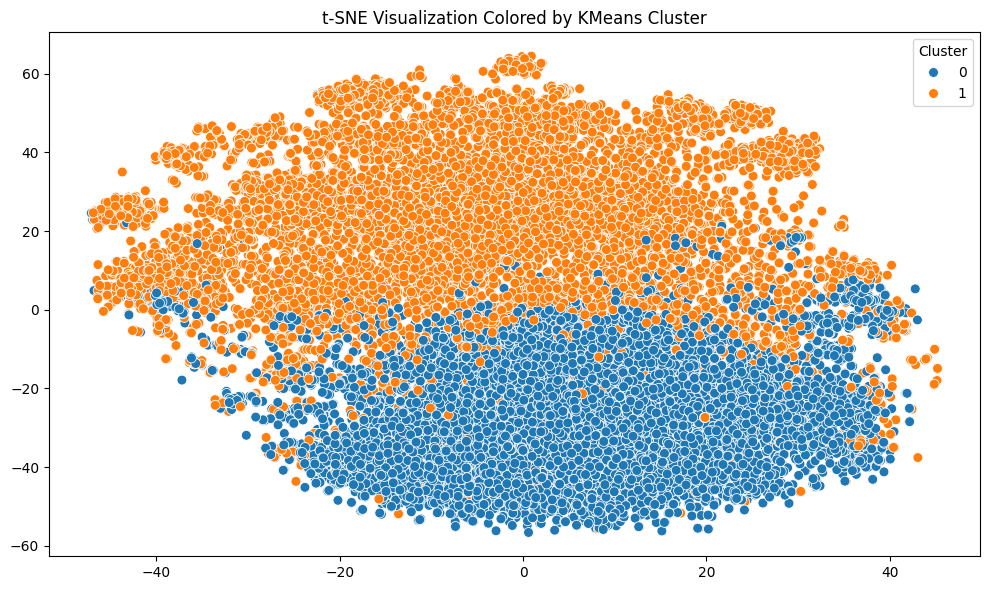

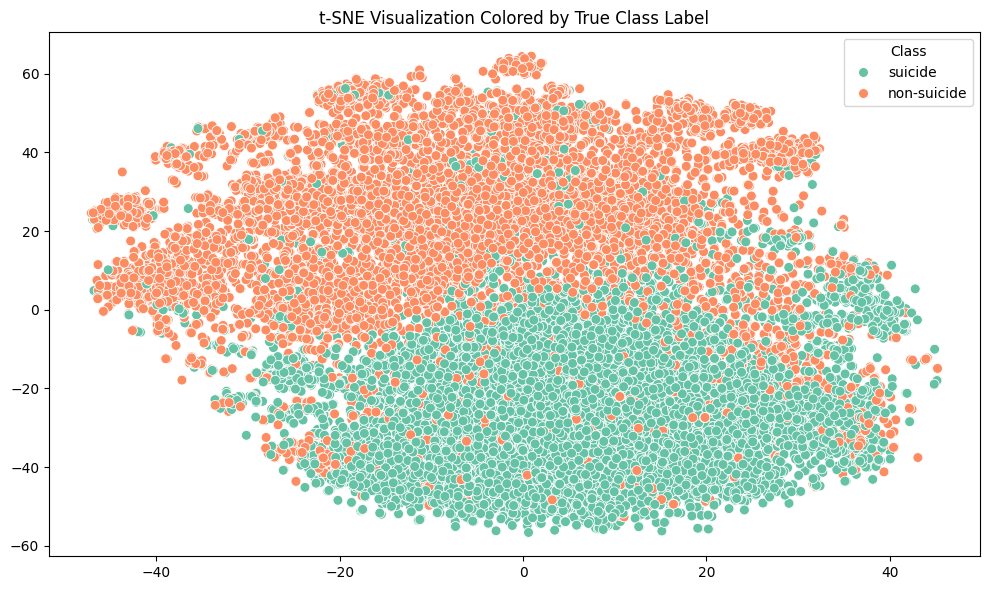


Cluster Purity (majority class % per cluster):
Cluster 0: 91.43% pure
Cluster 1: 87.87% pure

Sample post from each cluster:

--- Cluster 0 Sample ---
Ex Wife Threatening SuicideRecently I left my wife for good because she has cheated on me twice and lied to me so much that I have decided to refuse to go back to her. As of a few days ago, she began threatening suicide. I have tirelessly spent these paat few days talking her out of it and she keeps hesitating because she wants to believe I'll come back. I know a lot of people will threaten this in order to get their way, but what happens if she really does? What do I do and how am I supposed to handle her death on my hands? I still love my wife but I cannot deal with getting cheated on again and constantly feeling insecure. I'm worried today may be the day she does it and I hope so much it doesn't happen. suicide


--- Cluster 0 Sample ---
I’m so lostHello, my name is Adam (16) and I’ve been struggling for years and I’m afraid. Through

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

#text processing function
def preprocess_text(text):
    text = str(text).lower() #converting text to lowercase
    text = re.sub(r'u\/\w+', '', text) #removing user mentions
    text = re.sub(r'r\/\w+', '', text) #removing subreddi mentions
    text = re.sub(r'http\S+', '', text) #removing links
    text = re.sub(r'\bfiller\b', '', text) #removing the word filler (it appeared very frequently in non-suicide posts)
    text = re.sub(r'[^a-z\s]', '', text) #removing symbols and punctuation
    text = re.sub(r'\s+', ' ', text).strip() #removing excess whitespace
    return text

#loading the data
df = pd.read_csv('Suicide_Detection.csv',  nrows=20000,  engine='python') #reading a limited number of lines for stability
df = df.dropna(subset=['text', 'class']) #removing rows with missing values
df['clean_text'] = df['text'].apply(preprocess_text) #applying the text processing function

#use vectorization
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

#vecotrizing entries by batch to reduce memory use
def embed_text_batched(text_series, batch_size=512):
    embeddings = []
    for start in range(0, len(text_series), batch_size):
        batch = text_series.iloc[start:start + batch_size].tolist()
        embedded_batch = embed(batch).numpy()
        embeddings.append(embedded_batch) #embeding the current batch
        del embedded_batch #deleting the batch
        gc.collect() #freeing up memory
    return np.vstack(embeddings)

X_use = embed_text_batched(df['clean_text'])

svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X_use)

n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
df['cluster'] = kmeans.fit_predict(X_reduced)

print("\nPosts per Cluster:")
print(df['cluster'].value_counts().sort_index())

sil_score = silhouette_score(X_reduced, df['cluster'])
print(f"\nSilhouette Score (higher = better separation): {sil_score:.4f}")

print("\nClass distribution within each cluster:")
print(pd.crosstab(df['cluster'], df['class'], normalize='index'))

tsne = TSNE(n_components=2, perplexity=40, learning_rate=200, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_reduced)

plt.figure(figsize=(10,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=df['cluster'], palette='tab10', s=50)
plt.title("t-SNE Visualization Colored by KMeans Cluster")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=df['class'], palette='Set2', s=50)
plt.title("t-SNE Visualization Colored by True Class Label")
plt.legend(title="Class")
plt.tight_layout()
plt.show()

print("\nCluster Purity (majority class % per cluster):")
crosstab = pd.crosstab(df['cluster'], df['class'])
purity = crosstab.max(axis=1) / crosstab.sum(axis=1)
for cluster_id, score in purity.items():
    print(f"Cluster {cluster_id}: {score:.2%} pure")

print("\nSample post from each cluster:")
for cluster_id in sorted(df['cluster'].unique()):
    for i in range(5):
      sample_text = df[df['cluster'] == cluster_id]['text'].iloc[i]
      sample_class = df[df['cluster'] == cluster_id]['class'].iloc[i]
      print(f"\n--- Cluster {cluster_id} Sample ---\n{sample_text} {sample_class}\n" )

# ***Data Analysis: Word Cloud***

In [ ]:
!pip install wordcloud

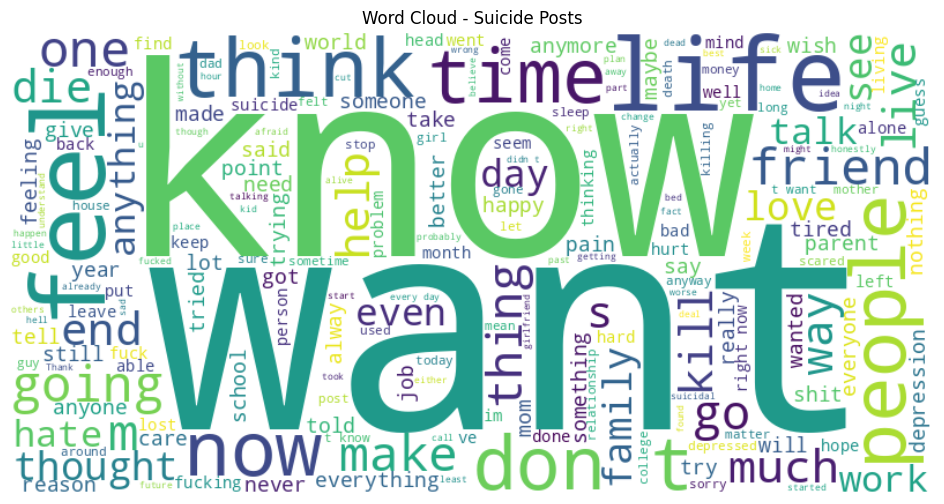

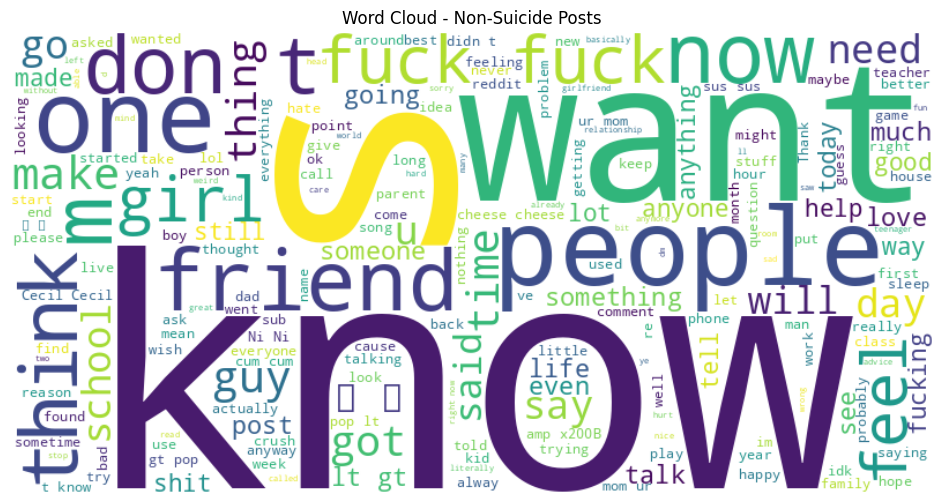

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df = pd.read_csv('Suicide_Detection.csv', engine='python')
df['text'] = df['text'].str.replace(r'\bfiller\b', '', case=False, regex=True)

suicide_text = ' '.join(df[df['class'] == 'suicide']['text'].dropna().tolist())
non_suicide_text = ' '.join(df[df['class'] == 'non-suicide']['text'].dropna().tolist())

suicide_wc = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(suicide_text)
non_suicide_wc = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(non_suicide_text)

# Display suicide word cloud
plt.figure(figsize=(12, 6))
plt.imshow(suicide_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Suicide Posts')
plt.show()

# Display non-suicide word cloud
plt.figure(figsize=(12, 6))
plt.imshow(non_suicide_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Non-Suicide Posts')
plt.show()

# ***Data Analysis: Class counts***

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('Suicide_Detection.csv', engine='python', nrows=500000000)
df['class'].value_counts()

class
suicide        116037
non-suicide    116037
Name: count, dtype: int64